# Pre-processing Colonies Dataset

* Data Pre-processing **[done]**
    * Import colonies
    * Import barrier files – reproject all to EPSG 7760
    * Check validity of all shapefiles (turn this into a function…) – also check that all points are in Delhi. (might be part of spatial index notebook and UAC deduplication)    
* Compute barrier clip for all colonies **[done]**
* Run Neighbors Algorithm **[done]**
    * Touching Neighbors algorithm - Modify so that it ignores NDMC and related areas (The NDMC / DCB polygons are coded as NDMC and DCB)
    * bbox Neighbors algorithm
    * Should check for barriers
    * Should check for NDMC and related areas
    * Save as two separate columns: touching neighbors and bbox neighbors 
* Additional preprocessing for colonies (turn into super function) **[done]**
    * Create index column **[done]**
    * Distance from NDMC **[done]**
    * Area of each polygon **[done]**
* Merge with 2020 Population data **[done]**
* Export GeoDataFrame as pickle file and ESRI Shapefiles

## Import modules and set constants

In [270]:
import os
import pickle
from importlib import reload
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, box
import spatial_index_utils

In [271]:
reload(spatial_index_utils)

<module 'spatial_index_utils' from 'C:\\Users\\bwbel\\Google Drive\\slum_project\\spatial_index_python\\spatial_index_utils.py'>

In [198]:
# WGS 84 / Delhi
epsg_code = 7760

## Import shapefiles **[done]**

In [182]:
#colony_filepath = os.path.join('shapefiles', 'Spatial_Index_GIS', 'Colony_Shapefile', 
#                        'Final_USO_fixed.shp')

colony_filepath = 'final_uso_deduplicated.shp'

barrier_directory = os.path.join('shapefiles', 'Barrier_Clip')

canal_filepath = os.path.join(barrier_directory, 'Canal', 'Canal.shp')
drain_filepath = os.path.join(barrier_directory, 'Drain', 'Major_Drain.shp')
railway_filepath = os.path.join(barrier_directory, 'Railway', 'Railway_Line.shp')

# boundary of Delhi
delhi_bounds_filepath = os.path.join('shapefiles', 'delhi_bounds_buffer.shp')

# Check that all filepaths exist
filepath_list = [colony_filepath, canal_filepath, drain_filepath, railway_filepath, delhi_bounds_filepath]

for filepath in filepath_list:
    if not os.path.exists(filepath):
        print('{} does not exist'.format(filepath))

In [51]:
colonies = gpd.read_file(colony_filepath)

In [52]:
canal = gpd.read_file(canal_filepath)

In [53]:
drain = gpd.read_file(drain_filepath)

In [54]:
railway = gpd.read_file(railway_filepath)

## Inspect shapefiles for validity (`check_shapefile`) **[done]**

In [199]:
spatial_index_utils.check_shapefile(gdf=colonies, gdf_name='colonies', 
                                    geom_type='Polygon', 
                                    delhi_bounds_filepath=delhi_bounds_filepath)

colonies has duplicate rows: False
----------------------------------------------------
rows with invalid geometries 

----------------------------------------------------
all geometries in colonies are of type Polygon: True
----------------------------------------------------
Rows with None value in geometry column are below
Empty GeoDataFrame
Columns: [index, AREA, USO_AREA_U, HOUSETAX_C, USO_FINAL, geometry, geom_type]
Index: []
----------------------------------------------------
colonies shapefile is contained within Delhi: True
----------------------------------------------------
Done with shapefile evaluation


In [200]:
spatial_index_utils.check_shapefile(gdf=canal, gdf_name='canal', geom_type='Line', 
                                    delhi_bounds_filepath=delhi_bounds_filepath)

canal has duplicate rows: False
----------------------------------------------------
rows with invalid geometries 

----------------------------------------------------
all geometries in canal are of type Line: True
----------------------------------------------------
Rows with None value in geometry column are below
Empty GeoDataFrame
Columns: [index, FID_1, CAN_NM, CAN_CLSF, EL_GND, DIST_NM, geometry, geom_type]
Index: []
----------------------------------------------------
canal shapefile is contained within Delhi: True
----------------------------------------------------
Done with shapefile evaluation


In [201]:
spatial_index_utils.check_shapefile(gdf=drain, gdf_name='drain', geom_type='Line', 
                                    delhi_bounds_filepath=delhi_bounds_filepath)

drain has duplicate rows: False
----------------------------------------------------
rows with invalid geometries 

----------------------------------------------------
all geometries in drain are of type Line: True
----------------------------------------------------
Rows with None value in geometry column are below
Empty GeoDataFrame
Columns: [index, FID, Drain_type, Drain_Name, MAINTAINED, AC_NAME, DISTRICT, geometry, geom_type]
Index: []
----------------------------------------------------
drain shapefile is contained within Delhi: True
----------------------------------------------------
Done with shapefile evaluation


In [202]:
spatial_index_utils.check_shapefile(gdf=railway, gdf_name='railway', geom_type='Line', 
                                    delhi_bounds_filepath=delhi_bounds_filepath)

railway has duplicate rows: False
----------------------------------------------------
rows with invalid geometries 

----------------------------------------------------
all geometries in railway are of type Line: True
----------------------------------------------------
Rows with None value in geometry column are below
Empty GeoDataFrame
Columns: [index, FID_1, RL_ZONE, geometry, geom_type]
Index: []
----------------------------------------------------
railway shapefile is contained within Delhi: True
----------------------------------------------------
Done with shapefile evaluation


## Remove duplicate geometries **[done]**

In [67]:
canal = spatial_index_utils.remove_duplicate_geom(canal)

Original number of rows is 43:
New number of rows after deduplication is 43:


In [68]:
drain = spatial_index_utils.remove_duplicate_geom(drain)

Original number of rows is 616:
New number of rows after deduplication is 616:


In [69]:
railway = spatial_index_utils.remove_duplicate_geom(railway)

Original number of rows is 5356:
New number of rows after deduplication is 5356:


In [70]:
colonies = spatial_index_utils.remove_duplicate_geom(colonies)

Original number of rows is 4319:
New number of rows after deduplication is 4290:


In [86]:
colonies.head()

,index,AREA,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry,geom_type
0,0,Singhola,3058,H,RV,"POLYGON Z ((1013763.588 1023721.838 0.000, 101...",<class 'geopandas.geoseries.GeoSeries'>
1,1,Indra Colony (Narela),1760,G,RUAC,"POLYGON Z ((1007997.730 1025421.961 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>
2,2,Bhor Garh,1276,H,Industrial,"POLYGON Z ((1008543.236 1022671.585 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>
3,3,Gautam Colony,1528,G,RUAC,"POLYGON Z ((1008080.674 1025132.190 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>
4,4,Kureni,2082,H,RV,"POLYGON Z ((1009508.695 1025281.671 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>


In [99]:
colonies_copy.to_file('final_uso_deduplicated.shp')

In [101]:
with open('final_uso_deduplicated.data', 'wb') as f:
    pickle.dump(colonies_copy, f)

## Check CRS, reproject to EPSG:7760.

In [203]:
colonies.crs

<Projected CRS: EPSG:7760>
Name: WGS 84 / Delhi
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: India - Delhi
- bounds: (76.83, 28.4, 77.34, 28.89)
Coordinate Operation:
- name: Delhi NSF LCC
- method: Lambert Conic Conformal (2SP)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [204]:
canal.crs

<Projected CRS: EPSG:7760>
Name: WGS 84 / Delhi
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: India - Delhi
- bounds: (76.83, 28.4, 77.34, 28.89)
Coordinate Operation:
- name: Delhi NSF LCC
- method: Lambert Conic Conformal (2SP)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [205]:
#drain = spatial_index_utils.reproject_gdf(drain, epsg_code)
drain.crs

<Projected CRS: EPSG:7760>
Name: WGS 84 / Delhi
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: India - Delhi
- bounds: (76.83, 28.4, 77.34, 28.89)
Coordinate Operation:
- name: Delhi NSF LCC
- method: Lambert Conic Conformal (2SP)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [206]:
railway.crs

<Projected CRS: EPSG:7760>
Name: WGS 84 / Delhi
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: India - Delhi
- bounds: (76.83, 28.4, 77.34, 28.89)
Coordinate Operation:
- name: Delhi NSF LCC
- method: Lambert Conic Conformal (2SP)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [207]:
colonies.crs == drain.crs == canal.crs == railway.crs

True

## Compute barrier clip

In [237]:
# Note... I had to reset index to make spatial join work!
#colonies = colonies.reset_index()
#colonies = colonies.drop(columns=['level_0', 'index'])

In [240]:
# Create new columns showing intersection with canal, railway and drain
colonies = spatial_index_utils.barrier_intersection(colonies, canal, "canal")

In [241]:
colonies = spatial_index_utils.barrier_intersection(colonies, railway, "railway")

In [242]:
colonies = spatial_index_utils.barrier_intersection(colonies, drain, "drain")

In [243]:
# Create barrier column as being intersection with canal, railway or drain
colonies['barrier'] = colonies['canal'] | colonies['railway'] | colonies["drain"]

In [244]:
colonies.head()

,AREA,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry,geom_type,canal,railway,drain,barrier
0,Singhola,3058,H,RV,"POLYGON Z ((1013763.588 1023721.838 0.000, 101...",<class 'geopandas.geoseries.GeoSeries'>,False,False,True,True
1,Indra Colony (Narela),1760,G,RUAC,"POLYGON Z ((1007997.730 1025421.961 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True
2,Bhor Garh,1276,H,Industrial,"POLYGON Z ((1008543.236 1022671.585 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True
3,Gautam Colony,1528,G,RUAC,"POLYGON Z ((1008080.674 1025132.190 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True
4,Kureni,2082,H,RV,"POLYGON Z ((1009508.695 1025281.671 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True


In [245]:
len(colonies)

4290

## Neighbors algorithm (while ignoring NDMC/DCB)

In [254]:
colonies = spatial_index_utils.add_polygon_neighbors_column(polygon_gdf=colonies, 
                                                 neighbor_colname='nbrs_touch',
                                                 neighbor_id_col='USO_AREA_U',
                                                 barrier_colname='barrier')

Record 0 of 4290
Record 100 of 4290
Record 200 of 4290
Record 300 of 4290
Record 400 of 4290
Record 500 of 4290
Record 600 of 4290
Record 700 of 4290
Record 800 of 4290
Record 900 of 4290
Record 1000 of 4290
Record 1100 of 4290
Record 1200 of 4290
Record 1300 of 4290
Record 1400 of 4290
Record 1500 of 4290
Record 1600 of 4290
Record 1700 of 4290
Record 1800 of 4290
Record 1900 of 4290
Record 2000 of 4290
Record 2100 of 4290
Record 2200 of 4290
Record 2300 of 4290
Record 2400 of 4290
Record 2500 of 4290
Record 2600 of 4290
Record 2700 of 4290
Record 2800 of 4290
Record 2900 of 4290
Record 3000 of 4290
Record 3100 of 4290
Record 3200 of 4290
Record 3300 of 4290
Record 3400 of 4290
Record 3500 of 4290
Record 3600 of 4290
Record 3700 of 4290
Record 3800 of 4290
Record 3900 of 4290
Record 4000 of 4290
Record 4100 of 4290
Record 4200 of 4290


In [255]:
colonies.head()

,AREA,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry,geom_type,canal,railway,drain,barrier,nbrs_touch
0,Singhola,3058,H,RV,"POLYGON Z ((1013763.588 1023721.838 0.000, 101...",<class 'geopandas.geoseries.GeoSeries'>,False,False,True,True,[]
1,Indra Colony (Narela),1760,G,RUAC,"POLYGON Z ((1007997.730 1025421.961 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5445]"
2,Bhor Garh,1276,H,Industrial,"POLYGON Z ((1008543.236 1022671.585 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,[5478]
3,Gautam Colony,1528,G,RUAC,"POLYGON Z ((1008080.674 1025132.190 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5095, 5105, 5436, 5457]"
4,Kureni,2082,H,RV,"POLYGON Z ((1009508.695 1025281.671 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[3963, 5092, 5098, 5104, 5106, 5451]"


## Neighbors algorithm with bounding box (while ignoring NDMC/DCB)

In [272]:
colonies = spatial_index_utils.add_polygon_neighbors_column_bbox(polygon_gdf=colonies, 
                                                 neighbor_colname='nbrs_bbox',
                                                 neighbor_id_col='USO_AREA_U',
                                                 barrier_colname='barrier')

Record 0 of 4290
Record 100 of 4290
Record 200 of 4290
Record 300 of 4290
Record 400 of 4290
Record 500 of 4290
Record 600 of 4290
Record 700 of 4290
Record 800 of 4290
Record 900 of 4290
Record 1000 of 4290
Record 1100 of 4290
Record 1200 of 4290
Record 1300 of 4290
Record 1400 of 4290
Record 1500 of 4290
Record 1600 of 4290
Record 1700 of 4290
Record 1800 of 4290
Record 1900 of 4290
Record 2000 of 4290
Record 2100 of 4290
Record 2200 of 4290
Record 2300 of 4290
Record 2400 of 4290
Record 2500 of 4290
Record 2600 of 4290
Record 2700 of 4290
Record 2800 of 4290
Record 2900 of 4290
Record 3000 of 4290
Record 3100 of 4290
Record 3200 of 4290
Record 3300 of 4290
Record 3400 of 4290
Record 3500 of 4290
Record 3600 of 4290
Record 3700 of 4290
Record 3800 of 4290
Record 3900 of 4290
Record 4000 of 4290
Record 4100 of 4290
Record 4200 of 4290


In [273]:
colonies.head()

,AREA,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry,geom_type,canal,railway,drain,barrier,nbrs_touch,nbrs_bbox
0,Singhola,3058,H,RV,"POLYGON Z ((1013763.588 1023721.838 0.000, 101...",<class 'geopandas.geoseries.GeoSeries'>,False,False,True,True,[],"[5108, 5487, 5488]"
1,Indra Colony (Narela),1760,G,RUAC,"POLYGON Z ((1007997.730 1025421.961 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5445]","[2869, 5445]"
2,Bhor Garh,1276,H,Industrial,"POLYGON Z ((1008543.236 1022671.585 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,[5478],"[4270, 4273, 5478]"
3,Gautam Colony,1528,G,RUAC,"POLYGON Z ((1008080.674 1025132.190 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5095, 5105, 5436, 5457]","[2869, 3963, 4243, 5092, 5095, 5105, 5436, 544..."
4,Kureni,2082,H,RV,"POLYGON Z ((1009508.695 1025281.671 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[3963, 5092, 5098, 5104, 5106, 5451]","[3963, 5092, 5095, 5098, 5104, 5106, 5451, 5478]"


In [275]:
colonies[colonies['USO_FINAL'] == 'NDMC']
# NDMC has USO_AREA_U of 3313

,AREA,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry,geom_type,canal,railway,drain,barrier,nbrs_touch,nbrs_bbox
1972,NDMC,3313,None,NDMC,MULTIPOLYGON Z (((1021746.475 1001273.220 0.00...,<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[1023, 1111, 3032, 2518, 1127, 1850, 1099, 160...","[2621, 2814, 1925, 1023, 1111, 1362, 3032, 251..."


In [289]:
# Make sure NDMC polygon was not included as neighbor
# in nbrs_touch

nbrs_touch_list = []

for nbrs_list in colonies['nbrs_touch']:
    nbrs_touch_list.extend(nbrs_list)
    
# NDMC not in neighbors list
3313 in nbrs_touch_list

False

In [290]:
# Make sure NDMC polygon was not included as neighbor
# in nbrs_bbox
nbrs_bbox_list = []

for nbrs_list in colonies['nbrs_bbox']:
    nbrs_bbox_list.extend(nbrs_list)

3313 in nbrs_bbox_list

False

## Calculate centroid for each polygon

In [292]:
colonies['centroid'] = colonies.centroid

In [293]:
colonies.head()

,AREA,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry,geom_type,canal,railway,drain,barrier,nbrs_touch,nbrs_bbox,centroid
0,Singhola,3058,H,RV,"POLYGON Z ((1013763.588 1023721.838 0.000, 101...",<class 'geopandas.geoseries.GeoSeries'>,False,False,True,True,[],"[5108, 5487, 5488]",POINT (1012643.931 1023967.383)
1,Indra Colony (Narela),1760,G,RUAC,"POLYGON Z ((1007997.730 1025421.961 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5445]","[2869, 5445]",POINT (1008331.501 1025234.188)
2,Bhor Garh,1276,H,Industrial,"POLYGON Z ((1008543.236 1022671.585 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,[5478],"[4270, 4273, 5478]",POINT (1009672.909 1022802.723)
3,Gautam Colony,1528,G,RUAC,"POLYGON Z ((1008080.674 1025132.190 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5095, 5105, 5436, 5457]","[2869, 3963, 4243, 5092, 5095, 5105, 5436, 544...",POINT (1008902.120 1025098.259)
4,Kureni,2082,H,RV,"POLYGON Z ((1009508.695 1025281.671 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[3963, 5092, 5098, 5104, 5106, 5451]","[3963, 5092, 5095, 5098, 5104, 5106, 5451, 5478]",POINT (1009491.379 1023952.320)


## Calculate neighbor distances

In [294]:
colonies = spatial_index_utils.calc_nbr_dist(polygon_gdf=colonies,
                                  nbr_dist_colname='nbrs_dist_touch',
                                  centroid_colname='centroid',
                                  neighbor_colname='nbrs_touch',
                                  neighbor_id_col='USO_AREA_U')

In [295]:
colonies.head()

,AREA,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry,geom_type,canal,railway,drain,barrier,nbrs_touch,nbrs_bbox,centroid,nbrs_dist_touch
0,Singhola,3058,H,RV,"POLYGON Z ((1013763.588 1023721.838 0.000, 101...",<class 'geopandas.geoseries.GeoSeries'>,False,False,True,True,[],"[5108, 5487, 5488]",POINT (1012643.931 1023967.383),[]
1,Indra Colony (Narela),1760,G,RUAC,"POLYGON Z ((1007997.730 1025421.961 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5445]","[2869, 5445]",POINT (1008331.501 1025234.188),"[(2869, 0.5868185653539563), (5445, 0.31827133..."
2,Bhor Garh,1276,H,Industrial,"POLYGON Z ((1008543.236 1022671.585 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,[5478],"[4270, 4273, 5478]",POINT (1009672.909 1022802.723),"[(5478, 0.661418841164336)]"
3,Gautam Colony,1528,G,RUAC,"POLYGON Z ((1008080.674 1025132.190 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5095, 5105, 5436, 5457]","[2869, 3963, 4243, 5092, 5095, 5105, 5436, 544...",POINT (1008902.120 1025098.259),"[(2869, 0.5676799818012491), (5095, 0.32048263..."
4,Kureni,2082,H,RV,"POLYGON Z ((1009508.695 1025281.671 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[3963, 5092, 5098, 5104, 5106, 5451]","[3963, 5092, 5095, 5098, 5104, 5106, 5451, 5478]",POINT (1009491.379 1023952.320),"[(3963, 0.6363487153623809), (5092, 1.29943169..."


In [296]:
colonies = spatial_index_utils.calc_nbr_dist(polygon_gdf=colonies,
                                  nbr_dist_colname='nbrs_dist_bbox',
                                  centroid_colname='centroid',
                                  neighbor_colname='nbrs_bbox',
                                  neighbor_id_col='USO_AREA_U')

In [297]:
colonies.head()

,AREA,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry,geom_type,canal,railway,drain,barrier,nbrs_touch,nbrs_bbox,centroid,nbrs_dist_touch,nbrs_dist_bbox
0,Singhola,3058,H,RV,"POLYGON Z ((1013763.588 1023721.838 0.000, 101...",<class 'geopandas.geoseries.GeoSeries'>,False,False,True,True,[],"[5108, 5487, 5488]",POINT (1012643.931 1023967.383),[],"[(5108, 1.4513506146004875), (5487, 1.17056023..."
1,Indra Colony (Narela),1760,G,RUAC,"POLYGON Z ((1007997.730 1025421.961 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5445]","[2869, 5445]",POINT (1008331.501 1025234.188),"[(2869, 0.5868185653539563), (5445, 0.31827133...","[(2869, 0.5868185653539563), (5445, 0.31827133..."
2,Bhor Garh,1276,H,Industrial,"POLYGON Z ((1008543.236 1022671.585 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,[5478],"[4270, 4273, 5478]",POINT (1009672.909 1022802.723),"[(5478, 0.661418841164336)]","[(4270, 0.8033104667179346), (4273, 0.58109669..."
3,Gautam Colony,1528,G,RUAC,"POLYGON Z ((1008080.674 1025132.190 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5095, 5105, 5436, 5457]","[2869, 3963, 4243, 5092, 5095, 5105, 5436, 544...",POINT (1008902.120 1025098.259),"[(2869, 0.5676799818012491), (5095, 0.32048263...","[(2869, 0.5676799818012491), (3963, 0.70232814..."
4,Kureni,2082,H,RV,"POLYGON Z ((1009508.695 1025281.671 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[3963, 5092, 5098, 5104, 5106, 5451]","[3963, 5092, 5095, 5098, 5104, 5106, 5451, 5478]",POINT (1009491.379 1023952.320),"[(3963, 0.6363487153623809), (5092, 1.29943169...","[(3963, 0.6363487153623809), (5092, 1.29943169..."


## Distance from NDMC

In [300]:
# ndmc_center shapefile location
ndmc_center_filepath = os.path.join('shapefiles', 'ndmc_center7760.shp')

os.path.exists(ndmc_center_filepath)

True

In [301]:
# Import shapefile
ndmc_center = gpd.read_file(ndmc_center_filepath)

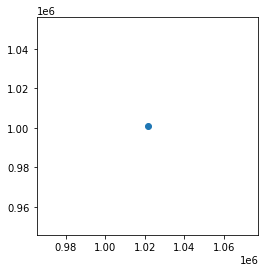

In [313]:
# Make sure this is just one point
ndmc_center.plot()

In [314]:
# See GeoDataFrame
ndmc_center.head()

,latitude,longitude,geometry
0,28.632846,77.219639,POINT (1021476.358 1000878.060)


In [315]:
# Ensure CRS is EPSG:7760
ndmc_center.crs

<Projected CRS: EPSG:7760>
Name: WGS 84 / Delhi
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: India - Delhi
- bounds: (76.83, 28.4, 77.34, 28.89)
Coordinate Operation:
- name: Delhi NSF LCC
- method: Lambert Conic Conformal (2SP)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [316]:
# Extract NDMC Center as Shapely Point
ndmc_center_point = ndmc_center['geometry'].values[0]

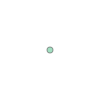

In [317]:
# View center point
ndmc_center_point

In [331]:
# Making sure I can compute distance in meters
# This is a test case to make sure I get correct results
colonies[colonies['USO_FINAL'] == 'NDMC']['centroid'].values[0].distance(ndmc_center_point)/1000

3.4805428722135723

In [328]:
# Code to generate ndmc_distances

# initialize new column with value 0
colonies['ndmc_dist_km'] = 0

# Compute distance from NDMC to centroid of each polygon
# Division by 1000 turns units into kilometers
for idx, row in colonies.iterrows():
    colonies.loc[idx, 'ndmc_dist_km'] = ndmc_center_point.distance(row['centroid'])/1000

In [329]:
colonies.head()

,AREA,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry,geom_type,canal,railway,drain,barrier,nbrs_touch,nbrs_bbox,centroid,nbrs_dist_touch,nbrs_dist_bbox,ndmc_dist_km
0,Singhola,3058,H,RV,"POLYGON Z ((1013763.588 1023721.838 0.000, 101...",<class 'geopandas.geoseries.GeoSeries'>,False,False,True,True,[],"[5108, 5487, 5488]",POINT (1012643.931 1023967.383),[],"[(5108, 1.4513506146004875), (5487, 1.17056023...",24.721016
1,Indra Colony (Narela),1760,G,RUAC,"POLYGON Z ((1007997.730 1025421.961 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5445]","[2869, 5445]",POINT (1008331.501 1025234.188),"[(2869, 0.5868185653539563), (5445, 0.31827133...","[(2869, 0.5868185653539563), (5445, 0.31827133...",27.676855
2,Bhor Garh,1276,H,Industrial,"POLYGON Z ((1008543.236 1022671.585 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,[5478],"[4270, 4273, 5478]",POINT (1009672.909 1022802.723),"[(5478, 0.661418841164336)]","[(4270, 0.8033104667179346), (4273, 0.58109669...",24.900046
3,Gautam Colony,1528,G,RUAC,"POLYGON Z ((1008080.674 1025132.190 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5095, 5105, 5436, 5457]","[2869, 3963, 4243, 5092, 5095, 5105, 5436, 544...",POINT (1008902.120 1025098.259),"[(2869, 0.5676799818012491), (5095, 0.32048263...","[(2869, 0.5676799818012491), (3963, 0.70232814...",27.289733
4,Kureni,2082,H,RV,"POLYGON Z ((1009508.695 1025281.671 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[3963, 5092, 5098, 5104, 5106, 5451]","[3963, 5092, 5095, 5098, 5104, 5106, 5451, 5478]",POINT (1009491.379 1023952.320),"[(3963, 0.6363487153623809), (5092, 1.29943169...","[(3963, 0.6363487153623809), (5092, 1.29943169...",26.001177


In [330]:
colonies[colonies['USO_FINAL'] == 'NDMC']

,AREA,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry,geom_type,canal,railway,drain,barrier,nbrs_touch,nbrs_bbox,centroid,nbrs_dist_touch,nbrs_dist_bbox,ndmc_dist_km
1972,NDMC,3313,None,NDMC,MULTIPOLYGON Z (((1021746.475 1001273.220 0.00...,<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[1023, 1111, 3032, 2518, 1127, 1850, 1099, 160...","[2621, 2814, 1925, 1023, 1111, 1362, 3032, 251...",POINT (1020019.324 997717.169),"[(1023, 5.045177313288549), (1111, 4.638570745...","[(2621, 4.30207733182986), (2814, 4.6295658161...",3.480543


In [332]:
# Min distance from NDMC in kilometers
colonies['ndmc_dist_km'].min()

0.8302865821400447

In [334]:
# Max distance from NDMC in kilometers
colonies['ndmc_dist_km'].max()

36.80718534491517

This seems to line up with [Wikipedia article](https://en.wikipedia.org/wiki/Delhi): The National Capital Territory of Delhi "...has a length of 51.9 km (32 mi) and a width of 48.48 km (30 mi)."

## Calculate Area (in square kilometers)

In [335]:
colonies['area_km2'] = colonies.area/1000000

In [336]:
colonies.head()

,AREA,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry,geom_type,canal,railway,drain,barrier,nbrs_touch,nbrs_bbox,centroid,nbrs_dist_touch,nbrs_dist_bbox,ndmc_dist_km,area_km2
0,Singhola,3058,H,RV,"POLYGON Z ((1013763.588 1023721.838 0.000, 101...",<class 'geopandas.geoseries.GeoSeries'>,False,False,True,True,[],"[5108, 5487, 5488]",POINT (1012643.931 1023967.383),[],"[(5108, 1.4513506146004875), (5487, 1.17056023...",24.721016,2.733999
1,Indra Colony (Narela),1760,G,RUAC,"POLYGON Z ((1007997.730 1025421.961 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5445]","[2869, 5445]",POINT (1008331.501 1025234.188),"[(2869, 0.5868185653539563), (5445, 0.31827133...","[(2869, 0.5868185653539563), (5445, 0.31827133...",27.676855,0.182393
2,Bhor Garh,1276,H,Industrial,"POLYGON Z ((1008543.236 1022671.585 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,[5478],"[4270, 4273, 5478]",POINT (1009672.909 1022802.723),"[(5478, 0.661418841164336)]","[(4270, 0.8033104667179346), (4273, 0.58109669...",24.900046,1.470808
3,Gautam Colony,1528,G,RUAC,"POLYGON Z ((1008080.674 1025132.190 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5095, 5105, 5436, 5457]","[2869, 3963, 4243, 5092, 5095, 5105, 5436, 544...",POINT (1008902.120 1025098.259),"[(2869, 0.5676799818012491), (5095, 0.32048263...","[(2869, 0.5676799818012491), (3963, 0.70232814...",27.289733,1.150775
4,Kureni,2082,H,RV,"POLYGON Z ((1009508.695 1025281.671 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[3963, 5092, 5098, 5104, 5106, 5451]","[3963, 5092, 5095, 5098, 5104, 5106, 5451, 5478]",POINT (1009491.379 1023952.320),"[(3963, 0.6363487153623809), (5092, 1.29943169...","[(3963, 0.6363487153623809), (5092, 1.29943169...",26.001177,2.415990


In [337]:
colonies['area_km2'].max()

43.29452020631941

In [338]:
colonies['area_km2'].min()

2.3028217018471078e-09

## Create index column

In [339]:
colonies['index'] = colonies.index

In [340]:
colonies.head()

,AREA,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry,geom_type,canal,railway,drain,barrier,nbrs_touch,nbrs_bbox,centroid,nbrs_dist_touch,nbrs_dist_bbox,ndmc_dist_km,area_km2,index
0,Singhola,3058,H,RV,"POLYGON Z ((1013763.588 1023721.838 0.000, 101...",<class 'geopandas.geoseries.GeoSeries'>,False,False,True,True,[],"[5108, 5487, 5488]",POINT (1012643.931 1023967.383),[],"[(5108, 1.4513506146004875), (5487, 1.17056023...",24.721016,2.733999,0
1,Indra Colony (Narela),1760,G,RUAC,"POLYGON Z ((1007997.730 1025421.961 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5445]","[2869, 5445]",POINT (1008331.501 1025234.188),"[(2869, 0.5868185653539563), (5445, 0.31827133...","[(2869, 0.5868185653539563), (5445, 0.31827133...",27.676855,0.182393,1
2,Bhor Garh,1276,H,Industrial,"POLYGON Z ((1008543.236 1022671.585 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,[5478],"[4270, 4273, 5478]",POINT (1009672.909 1022802.723),"[(5478, 0.661418841164336)]","[(4270, 0.8033104667179346), (4273, 0.58109669...",24.900046,1.470808,2
3,Gautam Colony,1528,G,RUAC,"POLYGON Z ((1008080.674 1025132.190 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5095, 5105, 5436, 5457]","[2869, 3963, 4243, 5092, 5095, 5105, 5436, 544...",POINT (1008902.120 1025098.259),"[(2869, 0.5676799818012491), (5095, 0.32048263...","[(2869, 0.5676799818012491), (3963, 0.70232814...",27.289733,1.150775,3
4,Kureni,2082,H,RV,"POLYGON Z ((1009508.695 1025281.671 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[3963, 5092, 5098, 5104, 5106, 5451]","[3963, 5092, 5095, 5098, 5104, 5106, 5451, 5478]",POINT (1009491.379 1023952.320),"[(3963, 0.6363487153623809), (5092, 1.29943169...","[(3963, 0.6363487153623809), (5092, 1.29943169...",26.001177,2.415990,4


## Save Colonies File (for backup)

In [341]:
with open('colonies_10August2020_2214.data', 'wb') as f:
    pickle.dump(colonies, f)

## Merge population data (2020) with colonies dataset

In [342]:
worldpop2020_filepath = os.path.join('population_data/', 'pop_colony_wp_2020.csv')
os.path.exists(worldpop2020_filepath)

True

In [343]:
# Import 2020 population data
worldpop2020 = pd.read_csv(worldpop2020_filepath)

In [344]:
# Inspect top of the dataframe
worldpop2020.head()

,Unnamed: 0,ID,layer,area,uso_area_u,housetax_c,uso_final
0,1,1,4415.586042,Singhola,3058,H,RV
1,2,2,3990.707763,Indra Colony (Narela),1760,G,RUAC
2,3,3,6849.523714,Bhor Garh,1276,H,Industrial
3,4,4,26712.165262,Gautam Colony,1528,G,RUAC
4,5,5,28819.392920,Kureni,2082,H,RV


In [345]:
# Restrict dataframe to only two columns:
# layer: population data
# uso_area_u: unique id for colonies
worldpop2020 = worldpop2020[['layer', 'uso_area_u']]
worldpop2020.head()

,layer,uso_area_u
0,4415.586042,3058
1,3990.707763,1760
2,6849.523714,1276
3,26712.165262,1528
4,28819.392920,2082


In [346]:
# Merge population data with colonies data
colonies = colonies.merge(worldpop2020, how='inner', 
                          left_on="USO_AREA_U", right_on='uso_area_u')

In [347]:
len(colonies)

4290

In [348]:
colonies.head()

,AREA,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry,geom_type,canal,railway,drain,barrier,nbrs_touch,nbrs_bbox,centroid,nbrs_dist_touch,nbrs_dist_bbox,ndmc_dist_km,area_km2,index,layer,uso_area_u
0,Singhola,3058,H,RV,"POLYGON Z ((1013763.588 1023721.838 0.000, 101...",<class 'geopandas.geoseries.GeoSeries'>,False,False,True,True,[],"[5108, 5487, 5488]",POINT (1012643.931 1023967.383),[],"[(5108, 1.4513506146004875), (5487, 1.17056023...",24.721016,2.733999,0,4415.586042,3058
1,Indra Colony (Narela),1760,G,RUAC,"POLYGON Z ((1007997.730 1025421.961 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5445]","[2869, 5445]",POINT (1008331.501 1025234.188),"[(2869, 0.5868185653539563), (5445, 0.31827133...","[(2869, 0.5868185653539563), (5445, 0.31827133...",27.676855,0.182393,1,3990.707763,1760
2,Bhor Garh,1276,H,Industrial,"POLYGON Z ((1008543.236 1022671.585 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,[5478],"[4270, 4273, 5478]",POINT (1009672.909 1022802.723),"[(5478, 0.661418841164336)]","[(4270, 0.8033104667179346), (4273, 0.58109669...",24.900046,1.470808,2,6849.523714,1276
3,Gautam Colony,1528,G,RUAC,"POLYGON Z ((1008080.674 1025132.190 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5095, 5105, 5436, 5457]","[2869, 3963, 4243, 5092, 5095, 5105, 5436, 544...",POINT (1008902.120 1025098.259),"[(2869, 0.5676799818012491), (5095, 0.32048263...","[(2869, 0.5676799818012491), (3963, 0.70232814...",27.289733,1.150775,3,26712.165262,1528
4,Kureni,2082,H,RV,"POLYGON Z ((1009508.695 1025281.671 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[3963, 5092, 5098, 5104, 5106, 5451]","[3963, 5092, 5095, 5098, 5104, 5106, 5451, 5478]",POINT (1009491.379 1023952.320),"[(3963, 0.6363487153623809), (5092, 1.29943169...","[(3963, 0.6363487153623809), (5092, 1.29943169...",26.001177,2.415990,4,28819.392920,2082


In [349]:
# Rename 'layer' column as 'population'
colonies = colonies.rename(columns={'layer': 'population'})

In [350]:
colonies.head()

,AREA,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry,geom_type,canal,railway,drain,barrier,nbrs_touch,nbrs_bbox,centroid,nbrs_dist_touch,nbrs_dist_bbox,ndmc_dist_km,area_km2,index,population,uso_area_u
0,Singhola,3058,H,RV,"POLYGON Z ((1013763.588 1023721.838 0.000, 101...",<class 'geopandas.geoseries.GeoSeries'>,False,False,True,True,[],"[5108, 5487, 5488]",POINT (1012643.931 1023967.383),[],"[(5108, 1.4513506146004875), (5487, 1.17056023...",24.721016,2.733999,0,4415.586042,3058
1,Indra Colony (Narela),1760,G,RUAC,"POLYGON Z ((1007997.730 1025421.961 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5445]","[2869, 5445]",POINT (1008331.501 1025234.188),"[(2869, 0.5868185653539563), (5445, 0.31827133...","[(2869, 0.5868185653539563), (5445, 0.31827133...",27.676855,0.182393,1,3990.707763,1760
2,Bhor Garh,1276,H,Industrial,"POLYGON Z ((1008543.236 1022671.585 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,[5478],"[4270, 4273, 5478]",POINT (1009672.909 1022802.723),"[(5478, 0.661418841164336)]","[(4270, 0.8033104667179346), (4273, 0.58109669...",24.900046,1.470808,2,6849.523714,1276
3,Gautam Colony,1528,G,RUAC,"POLYGON Z ((1008080.674 1025132.190 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[2869, 5095, 5105, 5436, 5457]","[2869, 3963, 4243, 5092, 5095, 5105, 5436, 544...",POINT (1008902.120 1025098.259),"[(2869, 0.5676799818012491), (5095, 0.32048263...","[(2869, 0.5676799818012491), (3963, 0.70232814...",27.289733,1.150775,3,26712.165262,1528
4,Kureni,2082,H,RV,"POLYGON Z ((1009508.695 1025281.671 0.000, 100...",<class 'geopandas.geoseries.GeoSeries'>,False,True,False,True,"[3963, 5092, 5098, 5104, 5106, 5451]","[3963, 5092, 5095, 5098, 5104, 5106, 5451, 5478]",POINT (1009491.379 1023952.320),"[(3963, 0.6363487153623809), (5092, 1.29943169...","[(3963, 0.6363487153623809), (5092, 1.29943169...",26.001177,2.415990,4,28819.392920,2082


## Remove extraneous columns (`uso_area_u` and `geom_type`)

In [351]:
colonies = colonies.drop(columns=['uso_area_u', 'geom_type'])

In [352]:
colonies.head()

,AREA,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry,canal,railway,drain,barrier,nbrs_touch,nbrs_bbox,centroid,nbrs_dist_touch,nbrs_dist_bbox,ndmc_dist_km,area_km2,index,population
0,Singhola,3058,H,RV,"POLYGON Z ((1013763.588 1023721.838 0.000, 101...",False,False,True,True,[],"[5108, 5487, 5488]",POINT (1012643.931 1023967.383),[],"[(5108, 1.4513506146004875), (5487, 1.17056023...",24.721016,2.733999,0,4415.586042
1,Indra Colony (Narela),1760,G,RUAC,"POLYGON Z ((1007997.730 1025421.961 0.000, 100...",False,True,False,True,"[2869, 5445]","[2869, 5445]",POINT (1008331.501 1025234.188),"[(2869, 0.5868185653539563), (5445, 0.31827133...","[(2869, 0.5868185653539563), (5445, 0.31827133...",27.676855,0.182393,1,3990.707763
2,Bhor Garh,1276,H,Industrial,"POLYGON Z ((1008543.236 1022671.585 0.000, 100...",False,True,False,True,[5478],"[4270, 4273, 5478]",POINT (1009672.909 1022802.723),"[(5478, 0.661418841164336)]","[(4270, 0.8033104667179346), (4273, 0.58109669...",24.900046,1.470808,2,6849.523714
3,Gautam Colony,1528,G,RUAC,"POLYGON Z ((1008080.674 1025132.190 0.000, 100...",False,True,False,True,"[2869, 5095, 5105, 5436, 5457]","[2869, 3963, 4243, 5092, 5095, 5105, 5436, 544...",POINT (1008902.120 1025098.259),"[(2869, 0.5676799818012491), (5095, 0.32048263...","[(2869, 0.5676799818012491), (3963, 0.70232814...",27.289733,1.150775,3,26712.165262
4,Kureni,2082,H,RV,"POLYGON Z ((1009508.695 1025281.671 0.000, 100...",False,True,False,True,"[3963, 5092, 5098, 5104, 5106, 5451]","[3963, 5092, 5095, 5098, 5104, 5106, 5451, 5478]",POINT (1009491.379 1023952.320),"[(3963, 0.6363487153623809), (5092, 1.29943169...","[(3963, 0.6363487153623809), (5092, 1.29943169...",26.001177,2.415990,4,28819.392920


## Save colonies file for Spatial Index

In [353]:
with open('colonies_10Aug2020.data', 'wb') as f:
    pickle.dump(colonies, f)